In [2]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV,
    cross_val_predict, cross_validate
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

1. Finding correlation between each type of predictor variables to target variables.

In [3]:
# Set Seeds for Reproducibility
random.seed(1244)
np.random.seed(1244)
tf.random.set_seed(1244)

print("Loading and cleaning data...")

# Step 1: Load data
client_df = pd.read_csv('/content/drive/MyDrive/IT1244 Project Sarah/Dataset it1244/client.csv')
invoice_df = pd.read_csv('/content/drive/MyDrive/IT1244 Project Sarah/Dataset it1244/invoice.csv')

# Step 2: Convert 'date' columns to datetime format
client_df['date'] = pd.to_datetime(client_df['date'], format='%d/%m/%Y', errors='coerce')
invoice_df['date'] = pd.to_datetime(invoice_df['date'], format='%d/%m/%Y', errors='coerce')

# Step 3: Basic data exploration
print("Client DataFrame Info:")
print(client_df.info())
print("\nInvoice DataFrame Info:")
print(invoice_df.info())

print("\nClient DataFrame Head:")
print(client_df.head())
print("\nInvoice DataFrame Head:")
print(invoice_df.head())

# Step 4: Handle missing values
client_df = client_df.fillna(method='ffill')  # Forward fill for client data
invoice_df = invoice_df.fillna(0)  # Replace missing values with 0 for invoice data

# Step 5: Merge data on common key (if available, e.g., 'client_id')
# Assuming 'client_id' is the common key in both datasets
merged_df = pd.merge(client_df, invoice_df, on='id', how='inner')

print("\nMerged DataFrame Info:")
print(merged_df.info())
print("\nMerged DataFrame Head:")
print(merged_df.head())



Loading and cleaning data...
Client DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21652 entries, 0 to 21651
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   region  21652 non-null  int64         
 1   date    21652 non-null  datetime64[ns]
 2   dis     21652 non-null  int64         
 3   id      21652 non-null  int64         
 4   catg    21652 non-null  int64         
 5   target  21652 non-null  int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 1015.1 KB
None

Invoice DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500651 entries, 0 to 500650
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    500651 non-null  int64         
 1   date                  500651 non-null  datetime64[ns]
 2   tarif_type            500651 non-null  int64  

<ipython-input-3-fd5c849e4ba0>:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  client_df = client_df.fillna(method='ffill')  # Forward fill for client data



Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500651 entries, 0 to 500650
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   region                500651 non-null  int64         
 1   date_x                500651 non-null  datetime64[ns]
 2   dis                   500651 non-null  int64         
 3   id                    500651 non-null  int64         
 4   catg                  500651 non-null  int64         
 5   target                500651 non-null  int64         
 6   date_y                500651 non-null  datetime64[ns]
 7   tarif_type            500651 non-null  int64         
 8   counter_statue        500651 non-null  int64         
 9   reading_remarque      500651 non-null  int64         
 10  consommation_level_4  500651 non-null  int64         
 11  months_number         500651 non-null  int64         
 12  counter_type          500651 non-n

In [8]:
# Separate features by type
X = merged_df.drop(columns=['target'])  # Features
y = merged_df['target']  # Target variable
numerical_features = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 'counter_coefficient']
categorical_features = ['dis', 'catg', 'region', 'months_number', 'counter_type']
ordinal_features = ['tarif_type', 'counter_statue', 'reading_remarque']

# Encode ordinal features if not already encoded
encoder = OrdinalEncoder()
X[ordinal_features] = encoder.fit_transform(X[ordinal_features])

# Dictionary to store correlations and p-values
correlations = {}

# Calculate Point-biserial correlation for numerical features
for column in numerical_features:
    correlation, p_value = pointbiserialr(merged_df[column], y)
    correlations[column] = {'correlation': correlation, 'p_value': p_value}

# Calculate Point-biserial correlation for ordinal features
for column in ordinal_features:
    correlation, p_value = pointbiserialr(merged_df[column], y)
    correlations[column] = {'correlation': correlation, 'p_value': p_value}

# Display correlations and p-values
print("Point-biserial Correlations and p-values for Numerical and Ordinal Features with Target:")
for feature, stats in correlations.items():
    print(f"{feature}: Correlation = {stats['correlation']}, p-value = {stats['p_value']}")

# Chi-square test for categorical features with binary target
chi2_results = {}
for feature in categorical_features:
    contingency_table = pd.crosstab(merged_df[feature], merged_df['target'])
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    chi2_results[feature] = {'chi2': chi2, 'p_value': p}

# Display the Chi-square test results
print("Chi-square Test Results for Categorical Features with Target:")
for feature, result in chi2_results.items():
    print(f"{feature}: Chi-square = {result['chi2']}, p-value = {result['p_value']}")

Point-biserial Correlations and p-values for Numerical and Ordinal Features with Target:
consommation_level_1: Correlation = 0.02477505700263692, p-value = 8.070574949672235e-69
consommation_level_2: Correlation = 0.007345799845428326, p-value = 2.0176681059940557e-07
consommation_level_3: Correlation = 0.03012021827602604, p-value = 7.920719177463544e-101
consommation_level_4: Correlation = 0.013322710843652143, p-value = 4.215643148162985e-21
counter_coefficient: Correlation = -0.000843270648041666, p-value = 0.550728351150056
tarif_type: Correlation = -0.0025972062087493124, p-value = 0.06610724206640818
counter_statue: Correlation = 0.005431793872923784, p-value = 0.00012135302054051574
reading_remarque: Correlation = 0.01732414356136487, p-value = 1.5056496612662735e-34
Chi-square Test Results for Categorical Features with Target:
dis: Chi-square = 1763.086989150621, p-value = 0.0
catg: Chi-square = 1860.242605859828, p-value = 0.0
region: Chi-square = 4969.587368437013, p-value =

2. Calculating the non-linear correlation/relationship with target variable

In [9]:
#Use decision tree to get non-linear relationship
from sklearn.ensemble import RandomForestClassifier

numerical_features = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 'counter_coefficient']
categorical_feature = ['dis', 'catg', 'region', 'months_number', 'counter_type']  # Replace with your numeric categorical columns
ordinal_features = ['tarif_type', 'counter_statue', 'reading_remarque']  # Replace with your ordinal feature names

#data clean for decision tree
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),  # Pass through numerical features as is
        ('ord', OrdinalEncoder(), ordinal_features),  # Ordinal encoding for ordinal features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encoding for categorical features
    ])

# Define pipeline with preprocessor and decision tree model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=1244))
])


# Train the model
pipeline.fit(X, y)

# Get feature importances
model = pipeline.named_steps['classifier']
feature_importances = model.feature_importances_

# Display feature importances
encoded_features = numerical_features + ordinal_features + list(pipeline.named_steps['preprocessor'].transformers_[2][1].get_feature_names_out(categorical_features))
importances_df = pd.DataFrame({'Feature': encoded_features, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

print(importances_df[:30])

                  Feature  Importance
0    consommation_level_1    0.426643
1    consommation_level_2    0.177229
3    consommation_level_4    0.072939
7        reading_remarque    0.060846
2    consommation_level_3    0.052192
5              tarif_type    0.025966
6          counter_statue    0.015018
42        months_number_4    0.013880
46        months_number_8    0.011361
40        months_number_2    0.007830
16             region_103    0.007558
31             region_310    0.006184
28             region_307    0.006053
14                catg_51    0.005421
13                catg_12    0.005096
192      counter_type_GAZ    0.005009
10                 dis_63    0.004812
23             region_302    0.004698
44        months_number_6    0.004613
17             region_104    0.004545
39        months_number_1    0.004382
20             region_107    0.004333
11                 dis_69    0.004279
191     counter_type_ELEC    0.004148
26             region_305    0.004107
12          

3. Finding out the relationship between date and target variable.

a. Date client joined to target variable

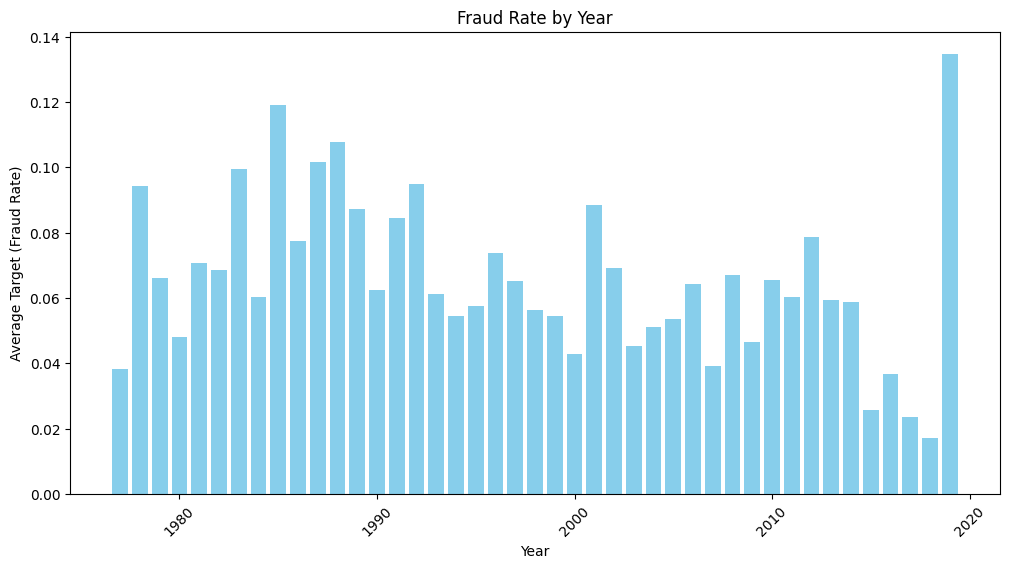

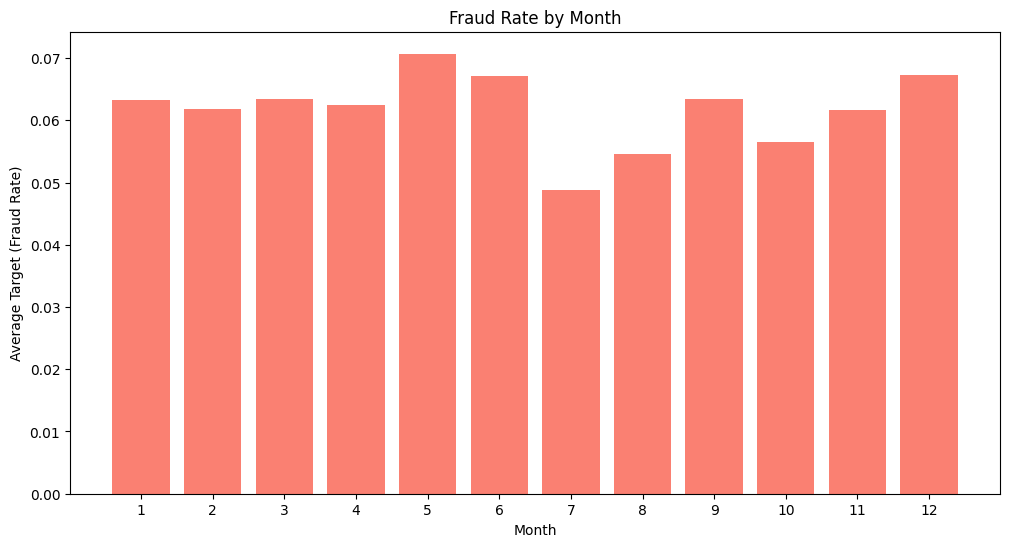

In [10]:
# Assuming 'date_x' is the relevant date column in datetime format (cilent join date)
# Extract year and month from the 'date_x' column
merged_df['year'] = merged_df['date_x'].dt.year
merged_df['month'] = merged_df['date_x'].dt.month

# Calculate the average target (fraud rate) by year
fraud_rate_by_year = merged_df.groupby('year')['target'].mean().reset_index()

# Calculate the average target (fraud rate) by month (aggregated across all years)
fraud_rate_by_month = merged_df.groupby('month')['target'].mean().reset_index()

# Plotting the fraud rate by year
plt.figure(figsize=(12, 6))
plt.bar(fraud_rate_by_year['year'], fraud_rate_by_year['target'], color='skyblue')
plt.title('Fraud Rate by Year')
plt.xlabel('Year')
plt.ylabel('Average Target (Fraud Rate)')
plt.xticks(rotation=45)
plt.show()

# Plotting the fraud rate by month
plt.figure(figsize=(12, 6))
plt.bar(fraud_rate_by_month['month'], fraud_rate_by_month['target'], color='salmon')
plt.title('Fraud Rate by Month')
plt.xlabel('Month')
plt.ylabel('Average Target (Fraud Rate)')
plt.xticks(range(1, 13))
plt.show()

b. Date of invoice transaction to target variable

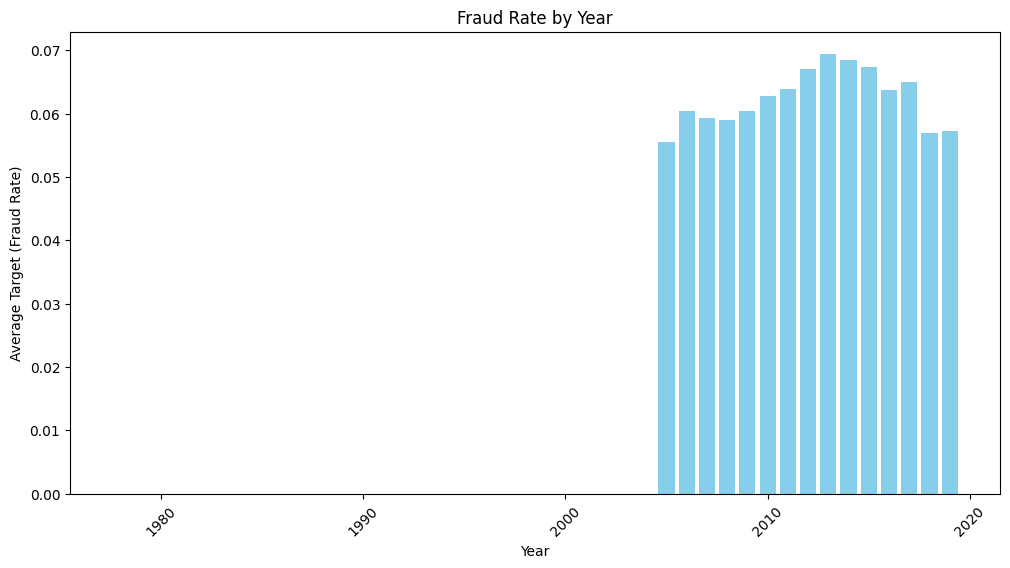

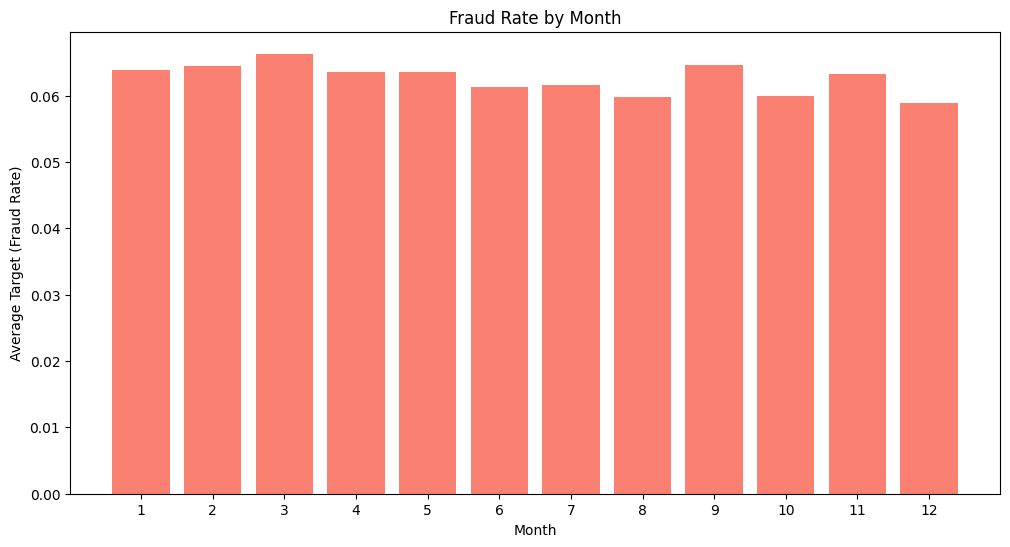

In [11]:
# Assuming 'date_y' is the relevant date column in datetime format (invoice transaction date)
# Extract year and month from the 'date_y' column
merged_df['year'] = merged_df['date_y'].dt.year
merged_df['month'] = merged_df['date_y'].dt.month

# Calculate the average target (fraud rate) by year
fraud_rate_by_year = merged_df.groupby('year')['target'].mean().reset_index()

# Calculate the average target (fraud rate) by month (aggregated across all years)
fraud_rate_by_month = merged_df.groupby('month')['target'].mean().reset_index()

# Plotting the fraud rate by year
plt.figure(figsize=(12, 6))
plt.bar(fraud_rate_by_year['year'], fraud_rate_by_year['target'], color='skyblue')
plt.title('Fraud Rate by Year')
plt.xlabel('Year')
plt.ylabel('Average Target (Fraud Rate)')
plt.xticks(rotation=45)
plt.show()

# Plotting the fraud rate by month
plt.figure(figsize=(12, 6))
plt.bar(fraud_rate_by_month['month'], fraud_rate_by_month['target'], color='salmon')
plt.title('Fraud Rate by Month')
plt.xlabel('Month')
plt.ylabel('Average Target (Fraud Rate)')
plt.xticks(range(1, 13))
plt.show()


4a. Aggregate invoice transactions to client id, to make new aggregated data that better represents each client's transaction patterns.

In [12]:
aggregated_df = merged_df.groupby('id').agg(
    # Consumption levels: sum, mean, std, max, min
    consommation_level_1_sum=('consommation_level_1', 'sum'),
    consommation_level_1_mean=('consommation_level_1', 'mean'),
    consommation_level_1_std=('consommation_level_1', 'std'),
    consommation_level_1_max=('consommation_level_1', 'max'),
    consommation_level_1_min=('consommation_level_1', 'min'),

    consommation_level_2_sum=('consommation_level_2', 'sum'),
    consommation_level_2_mean=('consommation_level_2', 'mean'),
    consommation_level_2_std=('consommation_level_2', 'std'),
    consommation_level_2_max=('consommation_level_2', 'max'),
    consommation_level_2_min=('consommation_level_2', 'min'),

    consommation_level_3_sum=('consommation_level_3', 'sum'),
    consommation_level_3_mean=('consommation_level_3', 'mean'),
    consommation_level_3_std=('consommation_level_3', 'std'),
    consommation_level_3_max=('consommation_level_3', 'max'),
    consommation_level_3_min=('consommation_level_3', 'min'),

    consommation_level_4_sum=('consommation_level_4', 'sum'),
    consommation_level_4_mean=('consommation_level_4', 'mean'),
    consommation_level_4_std=('consommation_level_4', 'std'),
    consommation_level_4_max=('consommation_level_4', 'max'),
    consommation_level_4_min=('consommation_level_4', 'min'),

    # Reading Remarque: mean (average)
    reading_remarque_mean=('reading_remarque', 'mean'),

    # Counter statue: mean and mode
    counter_statue_avg=('counter_statue', 'mean'),
    counter_statue_mode=('counter_statue', lambda x: x.mode()[0]),

    # Transactions per client
    total_transactions=('date_y', 'count'),  # Total transactions
    avg_transactions_per_month=('date_y', lambda x: x.nunique() / ((x.max() - x.min()).days / 30 if (x.max() - x.min()).days != 0 else 1)),  # Avg transactions per month
    transaction_period_length_days=('date_y', lambda x: (x.max() - x.min()).days)  # Length of transaction period in days
).reset_index()

# Step 2a: Calculate the mode for categorical variables
mode_df = merged_df.groupby('id').agg({
    'tarif_type': lambda x: x.mode()[0],  # Mode
    'counter_type': lambda x: x.mode()[0],
    'months_number': lambda x: x.mode()[0]
}).reset_index()

# Rename columns for clarity after calculating mode
mode_df.columns = ['id', 'tarif_type_mode', 'counter_type_mode', 'months_number_mode']

# Step 2b: Calculate the unique count for categorical variables
unique_count_df = merged_df.groupby('id').agg({
    'tarif_type': 'nunique',  # Unique count
    'counter_type': 'nunique',
    'months_number': 'nunique'
}).reset_index()

# Rename columns for clarity after calculating unique counts
unique_count_df.columns = ['id', 'tarif_type_unique_count', 'counter_type_unique_count', 'months_number_unique_count']

# Step 3: Merge all three DataFrames on 'id'
final_aggregated_df = aggregated_df.merge(mode_df, on='id').merge(unique_count_df, on='id')

# Display the final aggregated DataFrame
print(final_aggregated_df.head())

    id  consommation_level_1_sum  consommation_level_1_mean  \
0    0                     12334                 352.400000   
1    1                     20629                 557.540541   
2   10                     14375                 798.611111   
3   12                      5724                 357.750000   
4  100                        24                   1.200000   

   consommation_level_1_std  consommation_level_1_max  \
0                310.343472                      1200   
1                197.935960                      1207   
2                513.841374                      2400   
3                232.908995                       925   
4                  3.607011                        15   

   consommation_level_1_min  consommation_level_2_sum  \
0                        38                       370   
1                       190                         0   
2                       188                       682   
3                         7                      1

4b. Merge aggregate invoice to client. Then drop date, client id and counter_coefficient from final aggregated df.


In [13]:
# Flatten MultiIndex columns
final_aggregated_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col
                       for col in final_aggregated_df]

# Perform the merge
final_transformed_df = pd.merge(client_df, final_aggregated_df, left_on='id', right_on='id')

# Drop the specified columns from merged_df
final_transformed_df = final_transformed_df.drop(columns=['id', 'date'])

# Convert categorical columns into numerical ones using one-hot encoding

# Display the first few rows to confirm the columns were dropped
print(final_transformed_df.head())

   region  dis  catg  target  consommation_level_1_sum  \
0     101   60    11       0                     12334   
1     107   69    11       0                     20629   
2     301   62    11       0                     14375   
3     105   69    11       0                        24   
4     303   62    11       0                      9292   

   consommation_level_1_mean  consommation_level_1_std  \
0                 352.400000                310.343472   
1                 557.540541                197.935960   
2                 798.611111                513.841374   
3                   1.200000                  3.607011   
4                 663.714286                224.831365   

   consommation_level_1_max  consommation_level_1_min  \
0                      1200                        38   
1                      1207                       190   
2                      2400                       188   
3                        15                         0   
4                

5. Finding the correlation between target variable (fraud) and the new x feature variables

In [14]:
# Select numerical features
numerical_features = final_transformed_df.select_dtypes(include=['float64', 'int64']).drop(columns=['target', 'region', 'dis', 'catg', 'reading_remarque_mean',
                                                                                                    'tarif_type_mode', 'months_number_mode', 'counter_statue_mode', 'counter_statue_avg'])  # Exclude target to avoid self-correlation

# Calculate Pearson correlation between numerical features and the target variable
correlation_with_target = numerical_features.corrwith(final_transformed_df['target']).sort_values(ascending=False)

# Display the correlation results
print("Correlation of Numerical Features with Target Variable (Fraud):")
print(correlation_with_target)

# Initialize dictionaries to store results
chi2_results = {}
pointbiserial_results = {}

# Categorical variables to test with Chi-square
categorical_features = ['region', 'dis', 'catg', 'tarif_type_mode', 'counter_type_mode', 'months_number_mode']  # Adjust as needed

# Chi-square test for categorical features with the target
for feature in categorical_features:
    contingency_table = pd.crosstab(final_transformed_df[feature], final_transformed_df['target'])
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    chi2_results[feature] = {'chi2': chi2, 'p_value': p}

# Ordinal variables to test with Point-biserial
ordinal_features = ['reading_remarque_mean', 'counter_statue_avg']  # Adjust as needed

# Point-biserial correlation for ordinal features with the binary target
for feature in ordinal_features:
    correlation, p_value = pointbiserialr(final_transformed_df[feature], final_transformed_df['target'])
    pointbiserial_results[feature] = {'correlation': correlation, 'p_value': p_value}

# Display Chi-square results
print("Chi-square Test Results for Categorical Features with Target:")
for feature, result in chi2_results.items():
    print(f"{feature}: Chi-square = {result['chi2']}, p-value = {result['p_value']}")

# Display Point-biserial correlation results
print("\nPoint-biserial Correlation Results for Ordinal Features with Target:")
for feature, result in pointbiserial_results.items():
    print(f"{feature}: Correlation = {result['correlation']}, p-value = {result['p_value']}")


Correlation of Numerical Features with Target Variable (Fraud):
months_number_unique_count        0.108873
transaction_period_length_days    0.108058
consommation_level_3_max          0.101663
consommation_level_3_std          0.101656
total_transactions                0.099413
consommation_level_1_sum          0.098423
consommation_level_3_sum          0.078073
consommation_level_1_max          0.056624
consommation_level_4_max          0.043312
consommation_level_1_std          0.037551
consommation_level_4_std          0.036014
consommation_level_2_sum          0.033393
tarif_type_unique_count           0.033191
consommation_level_1_mean         0.032812
consommation_level_3_mean         0.025687
consommation_level_4_sum          0.022842
consommation_level_4_mean         0.022053
counter_type_unique_count         0.019978
consommation_level_2_mean         0.019938
consommation_level_2_std          0.018640
consommation_level_2_max          0.017070
consommation_level_4_min         